In [1]:
from torch.utils.data import Dataset, DataLoader
import h5py
import os
from torchvision import transforms
import numpy as np
import logging
import torch
from functools import partial
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block
import glob
import argparse
from functools import partial
import torch.nn as nn
from PIL import Image
from timm.models.vision_transformer import PatchEmbed, Block
import matplotlib.pyplot as plt
import timm.optim as optim_factory
import math
from collections import defaultdict, deque
import torch.distributed as dist
from pathlib import Path
import time
import builtins
import datetime
from typing import Iterable
import sys
import json
import torchvision.transforms.functional as TF


In [2]:
class Args:
    batch_size = 128
    epochs = 900
    accum_iter = 1
    mask_ratio = 0.45
    model = 'mae_vit_base_patch16_dec512d8b'
    input_size = 224
    norm_pix_loss = False
    weight_decay = 0.05
    lr = None
    blr = 1.5e-4
    min_lr = 0.
    warmup_epochs = 10
    data_path = '/kaggle/input/train-dataset/ACDC/data/slices'
    output_dir = '/kaggle/working/mae_acdc_output'
    log_dir = '/kaggle/working/mae_acdc_logs'
    device = 'cuda'
    seed = 42
    resume = ''
    start_epoch = 0
    num_workers = 0
    pin_mem = True
    distributed = False

args = Args()
np.random.seed(args.seed)

In [3]:
class ACDCDataset(Dataset):
    def __init__(self, h5_dir_path, transform=None):
        self.h5_file_list = sorted(glob.glob(os.path.join(h5_dir_path, '*.h5')))
        self.transform = transform
        self.dataset_length = len(self.h5_file_list)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        h5_path = self.h5_file_list[idx]

        with h5py.File(h5_path, 'r') as h5_file:
            image = h5_file['image'][()]  # shape: (H, W) or (1, H, W)

        if image.ndim == 2:
            image = np.expand_dims(image, axis=0)

        image = torch.tensor(image, dtype=torch.float32)  # shape: (1, H, W)

        if self.transform:
            image = self.transform(image)  # shape: (3, 224, 224)

        return image

In [4]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [5]:
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [6]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if v is None:
                continue
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = [
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}'
        ]
        if torch.cuda.is_available():
            log_msg.append('max mem: {memory:.0f}')
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    builtin_print = builtins.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        force = force or (get_world_size() > 8)
        if is_master or force:
            now = datetime.datetime.now().time()
            builtin_print('[{}] '.format(now), end='')  # print with time stamp
            builtin_print(*args, **kwargs)

    builtins.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if args.dist_on_itp:
        args.rank = int(os.environ['OMPI_COMM_WORLD_RANK'])
        args.world_size = int(os.environ['OMPI_COMM_WORLD_SIZE'])
        args.gpu = int(os.environ['OMPI_COMM_WORLD_LOCAL_RANK'])
        args.dist_url = "tcp://%s:%s" % (os.environ['MASTER_ADDR'], os.environ['MASTER_PORT'])
        os.environ['LOCAL_RANK'] = str(args.gpu)
        os.environ['RANK'] = str(args.rank)
        os.environ['WORLD_SIZE'] = str(args.world_size)
        # ["RANK", "WORLD_SIZE", "MASTER_ADDR", "MASTER_PORT", "LOCAL_RANK"]
    elif 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        setup_for_distributed(is_master=True)  # hack
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}, gpu {}'.format(
        args.rank, args.dist_url, args.gpu), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


class NativeScalerWithGradNormCount:
    state_dict_key = "amp_scaler"

    def __init__(self):
        self._scaler = torch.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)
        if update_grad:
            if clip_grad is not None:
                assert parameters is not None
                self._scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                norm = torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            else:
                self._scaler.unscale_(optimizer)
                norm = get_grad_norm_(parameters)
            self._scaler.step(optimizer)
            self._scaler.update()
        else:
            norm = None
        return norm

    def state_dict(self):
        return self._scaler.state_dict()

    def load_state_dict(self, state_dict):
        self._scaler.load_state_dict(state_dict)


def get_grad_norm_(parameters, norm_type: float = 2.0) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    if norm_type == math.inf:
        total_norm = max(p.grad.detach().abs().max().to(device) for p in parameters)
    else:
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
    return total_norm


def save_model(args, epoch, model, model_without_ddp, optimizer, loss_scaler):
    output_dir = Path(args.output_dir)
    epoch_name = str(epoch)
    if loss_scaler is not None:
        checkpoint_paths = [output_dir / ('checkpoint-%s.pth' % epoch_name)]
        for checkpoint_path in checkpoint_paths:
            to_save = {
                'model': model_without_ddp.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'scaler': loss_scaler.state_dict(),
                'args': args,
            }

            save_on_master(to_save, checkpoint_path)
    else:
        client_state = {'epoch': epoch}
        model.save_checkpoint(save_dir=args.output_dir, tag="checkpoint-%s" % epoch_name, client_state=client_state)


def load_model(args, model_without_ddp, optimizer, loss_scaler):
    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])
        print("Resume checkpoint %s" % args.resume)
        if 'optimizer' in checkpoint and 'epoch' in checkpoint and not (hasattr(args, 'eval') and args.eval):
            optimizer.load_state_dict(checkpoint['optimizer'])
            args.start_epoch = checkpoint['epoch'] + 1
            if 'scaler' in checkpoint:
                loss_scaler.load_state_dict(checkpoint['scaler'])
            print("With optim & sched!")


def all_reduce_mean(x):
    world_size = get_world_size()
    if world_size > 1:
        x_reduce = torch.tensor(x).cuda()
        dist.all_reduce(x_reduce)
        x_reduce /= world_size
        return x_reduce.item()
    else:
        return x

In [7]:
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < args.warmup_epochs:
        lr = args.lr * epoch / args.warmup_epochs 
    else:
        lr = args.min_lr + (args.lr - args.min_lr) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - args.warmup_epochs) / (args.epochs - args.warmup_epochs)))
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr
    return lr

In [8]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': decay, 'weight_decay': weight_decay},
        {'params': no_decay, 'weight_decay': 0.0},
    ]


In [9]:
def train_one_epoch(model: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, loss_scaler,
                    log_writer=None,
                    args=None):
    model.train(True)
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.2e}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 20

    accum_iter = args.accum_iter

    optimizer.zero_grad()

    if log_writer is not None:
        print('log_dir: {}'.format(log_writer.log_dir))

    for data_iter_step, samples in enumerate(metric_logger.log_every(data_loader, print_freq, header)):

        # we use a per iteration (instead of per epoch) lr scheduler
        if data_iter_step % accum_iter == 0:
            lr = adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, args)

        samples = samples.to(device, non_blocking=True)

        with torch.amp.autocast(device_type='cuda'):
            loss, _, _ = model(samples, mask_ratio=args.mask_ratio)

        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        loss /= accum_iter
        loss_scaler(loss, optimizer, parameters=model.parameters(),
                    update_grad=(data_iter_step + 1) % accum_iter == 0)
        if (data_iter_step + 1) % accum_iter == 0:
            optimizer.zero_grad()

        torch.cuda.synchronize()

        metric_logger.update(loss=loss_value)

        lr = optimizer.param_groups[0]["lr"]
        metric_logger.update(lr=lr)

        loss_value_reduce = all_reduce_mean(loss_value)
        if log_writer is not None and (data_iter_step + 1) % accum_iter == 0:
            """ We use epoch_1000x as the x-axis in tensorboard.
            This calibrates different curves when batch size changes.
            """
            epoch_1000x = int((data_iter_step / len(data_loader) + epoch) * 1000)
            log_writer.add_scalar('train_loss', loss_value_reduce, epoch_1000x)
            log_writer.add_scalar('lr', lr, epoch_1000x)


    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

torch.Size([3, 224, 224])
torch.Size([224, 224])


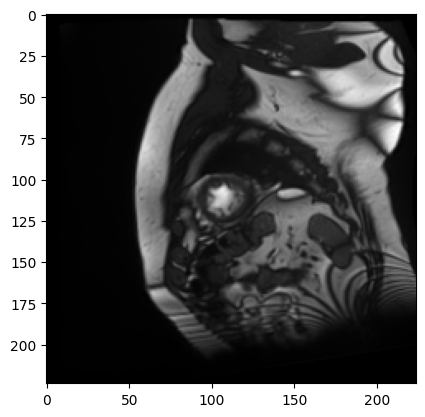

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # (1, H, W) → (3, H, W)
    transforms.Normalize(mean=[0.5], std=[0.5])

])

# acdc dataset
dataset_train = ACDCDataset(h5_dir_path=args.data_path, transform=transform)
print(dataset_train[0].shape)

# acdc DataLoader
data_loader_train = DataLoader(dataset_train, batch_size=args.batch_size,
                            shuffle=True, num_workers=0, pin_memory=args.pin_mem, drop_last=True)

# Lấy 1 batch từ data_loader
images = dataset_train[1]
gray_images = images[0]  
print(gray_images.shape)

plt.imshow(gray_images, cmap='gray')


In [11]:
device = torch.device(args.device)
model = mae_vit_base_patch16_dec512d8b(norm_pix_loss=args.norm_pix_loss)
model.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2

torch.Size([1, 196, 768])


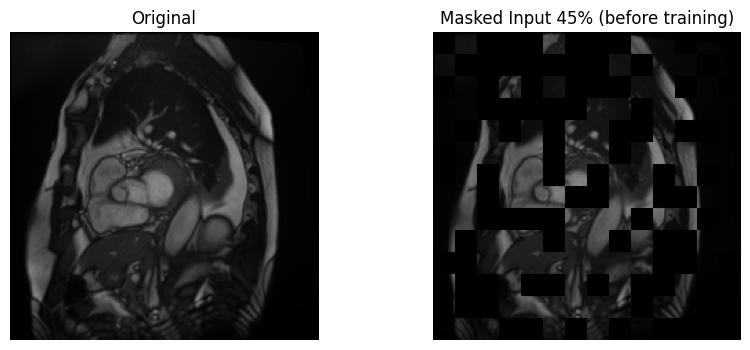

In [12]:
# Lấy ảnh (giả sử lấy ảnh đầu tiên)
img = dataset_train[0].unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)

patches = model.patch_embed(img)
print(patches.shape)  # shape: (1, num_patches, embed_dim)

masked_patches, mask, ids_restore = model.random_masking(patches, args.mask_ratio)

# Unnormalize ảnh để hiển thị
img_vis = img.detach().cpu() * 0.5 + 0.5

# Tạo ảnh masked từ mask vector
def visualize_masked_input(img_tensor, mask, patch_size=16):
    """
    img_tensor: (1, 3, 224, 224)
    mask: (1, num_patches), 0: keep, 1: mask
    """
    img_tensor = img_tensor[0]  # (3, 224, 224)
    mask = mask[0]  # (num_patches,)
    H, W = img_tensor.shape[1], img_tensor.shape[2]
    h = w = H // patch_size
    mask = mask.reshape(h, w)

    # Apply mask bằng cách gán vùng đó về 0
    img_np = img_tensor.permute(1, 2, 0).numpy().copy()
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 1:
                img_np[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0.0  # black out

    # Vẽ ảnh
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_tensor.permute(1, 2, 0))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.title('Masked Input 45% (before training)')
    plt.axis('off')
    plt.show()

visualize_masked_input(img_vis, mask)

In [13]:
eff_batch_size = args.batch_size * args.accum_iter
if args.lr is None:
    args.lr = args.blr * eff_batch_size / 256

param_groups = add_weight_decay(model, args.weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=args.lr, betas=(0.9, 0.95))
loss_scaler = NativeScalerWithGradNormCount()


for epoch in range(args.start_epoch, args.epochs):


    train_stats = train_one_epoch(
        model, data_loader_train,
        optimizer, device, epoch, loss_scaler,
        log_writer=None,  # hoặc truyền SummaryWriter nếu bạn dùng TensorBoard
        args=args
    )

    # Save model each 20 epochs
    if (epoch + 1) % 20 == 0:
        save_path = os.path.join(args.output_dir, f'checkpoint-epoch{epoch+1}.pth')
        torch.save(model.state_dict(), save_path)

    # Log stats
    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()}, 'epoch': epoch}
    print(log_stats)

    # Ghi log ra file nếu muốn
    os.makedirs(args.output_dir, exist_ok=True)
    with open(os.path.join(args.output_dir, "log.txt"), "a") as f:
        f.write(json.dumps(log_stats) + "\n")

Epoch: [0]  [ 0/14]  eta: 0:01:02  lr: 0.00e+00  loss: 1.2588 (1.2588)  time: 4.4486  data: 2.2064  max mem: 9559
Epoch: [0]  [13/14]  eta: 0:00:03  lr: 6.96e-06  loss: 1.0003 (1.0315)  time: 3.8781  data: 1.9840  max mem: 10423
Epoch: [0] Total time: 0:00:54 (3.8787 s / it)
Averaged stats: lr: 6.96e-06  loss: 1.0003 (1.0315)
{'train_lr': 3.4821428571428568e-06, 'train_loss': 1.031523470367704, 'epoch': 0}
Epoch: [1]  [ 0/14]  eta: 0:00:43  lr: 7.50e-06  loss: 0.7324 (0.7324)  time: 3.1113  data: 1.2446  max mem: 10423
Epoch: [1]  [13/14]  eta: 0:00:03  lr: 1.45e-05  loss: 0.5300 (0.5526)  time: 3.0874  data: 1.2201  max mem: 10423
Epoch: [1] Total time: 0:00:43 (3.0876 s / it)
Averaged stats: lr: 1.45e-05  loss: 0.5300 (0.5526)
{'train_lr': 1.0982142857142856e-05, 'train_loss': 0.5526394695043564, 'epoch': 1}
Epoch: [2]  [ 0/14]  eta: 0:00:42  lr: 1.50e-05  loss: 0.3986 (0.3986)  time: 3.0005  data: 1.1340  max mem: 10423
Epoch: [2]  [13/14]  eta: 0:00:03  lr: 2.20e-05  loss: 0.3099 (

# evaluation

In [14]:
def visualize_full(img_tensor, recon_tensor, mask, patch_size=16):
    """
    Show image Original | Masked Input | Reconstruction
    """
    img_tensor = img_tensor[0].detach().cpu() * 0.5 + 0.5
    img_tensor = img_tensor.clamp(0, 1)
    recon_tensor = recon_tensor[0].detach().cpu() * 0.5 + 0.5
    recon_tensor = recon_tensor.clamp(0, 1)
    mask = mask[0].detach().cpu()

    H, W = img_tensor.shape[1:]
    h = H // patch_size
    w = W // patch_size
    mask = mask.reshape(h, w)

    masked_img = img_tensor.clone().numpy().transpose(1, 2, 0)
    for i in range(h):
        for j in range(w):
            if mask[i, j] == 1:
                masked_img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0.0

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_tensor.permute(1, 2, 0))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masked_img)
    plt.title('Masked Input')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(recon_tensor.permute(1, 2, 0))
    plt.title('Reconstruction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


<ipython-input-15-1da50d887360>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/mae_acdc_output/checkpoint-epoch900.pth', 

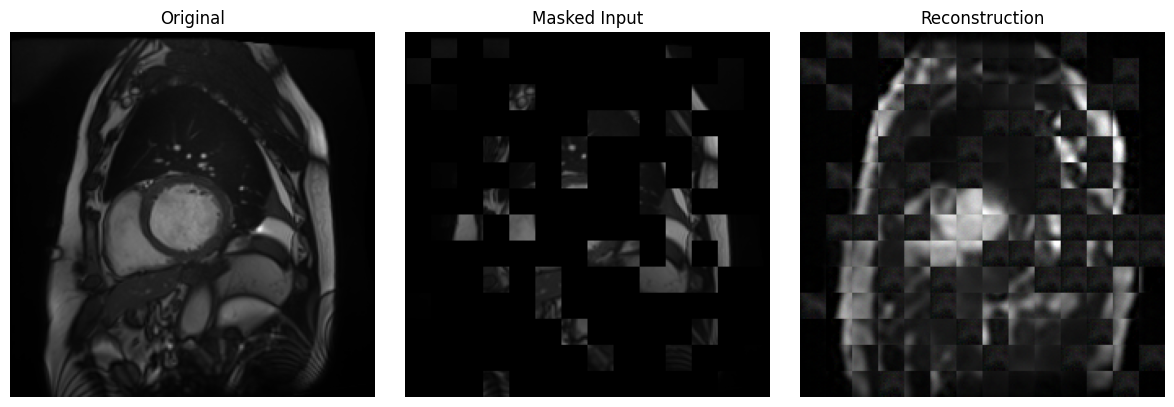

In [15]:
# Load checkpoint đã train
model.load_state_dict(torch.load('/kaggle/working/mae_acdc_output/checkpoint-epoch900.pth', map_location=device))
model.eval()

# Lấy ảnh test từ dataset
img = dataset_train[3].unsqueeze(0).to(device)  # (1, 3, 224, 224)

# Chạy qua mô hình MAE
with torch.no_grad():
    loss, pred, mask = model(img, mask_ratio=0.75)
    recon_imgs = model.unpatchify(pred)  # (1, 3, 224, 224)

# Visualize
visualize_full(img, recon_imgs, mask)
